In [6]:
# Import the required libraries
import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
from torch.autograd import Variable
import math
import numpy as npP
from natsort import natsorted
from PIL import Image
import random
import pickle
import pandas as pd


In [2]:
# Code to upload dataset to google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    path_to_zip_file = 'drive/MyDrive/data.zip'
    directory_to_extract_to = 'VISCHEMA_PLUS/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    !cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
    !cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"
except:
    print("not on google colab")

not on google colab


In [7]:
# Create datasets and dataloaders
class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

image_transforms = transforms.Compose([
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])

batch_size = 8

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


c:\Users\bluep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


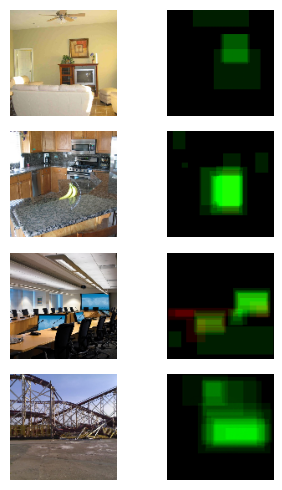

In [4]:
# Examine some image label pairs

import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [16]:
from torchvision.models import resnet50, resnet18
model = nn.Sequential(resnet50(weights=None), nn.Linear(1000, 511)) 
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in Model')

26068543 Parameters in Model


In [20]:
model.eval()
images, labels = next(iter(train_loader))

In [24]:
output = model(images)
print(output.size())
print(torch.argmax(output))

torch.Size([8, 511])
tensor(490)


In [8]:
from torchvision.models import resnet50, resnet18
def train(save_dir):

    ###################################
    # Set up our training environment #
    ###################################
    L1Loss = nn.L1Loss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = nn.Sequential(resnet50(weights=None), nn.Linear(1000, 511)) 
    optim = torch.optim.Adam(model.parameters())
    train_losses = []
    val_losses = []

    num_epochs = 100
    
    #######################
    # Start Training Loop #
    #######################

    print(f'Starting Training for {save_dir}')
    for epoch in range(num_epochs):

        # Go into training mode
        model.train()

        # Train the model and evaluate on the training set
        total_train_loss = 0
        total_val_loss = 0

        for i, (images, labels) in enumerate(train_loader):

            # Move images to device and create an image prediction
            images, labels = images.to(device), labels.to(device)
            optim.zero_grad()
            
            output = model(images)
            loss = L1Loss(labels, output)
            
            # Logging
            batch_loss = loss.item() * batch_size
            total_train_loss += batch_loss

            # Backprop
            loss.backward()
            optim.step()

            # Clear memory
            del images, labels, output 
            torch.cuda.empty_cache() 

        model.eval()
        with torch.no_grad():
          for i, (images, labels) in enumerate(val_loader):

            # Move images to device and create an image prediction
            images, labels = images.to(device), labels.to(device)
            output = model(images)

            loss = L1Loss(output, images)
            batch_loss = loss.item() * batch_size
            total_val_loss += batch_loss

            # Clear memory
            del images, labels, output
            torch.cuda.empty_cache() 

        train_losses.append( total_train_loss/ len(train_loader))
        val_losses.append( total_val_loss / len(val_loader))

        print(f'Epoch [{epoch + 1}/{num_epochs}], D: {loss_D.item():.4f}, G: {loss_G.item():.4f},  Val Loss: {val_losses[-1]} Train Loss: {train_losses[-1]}')

    print(f"Graph for {save_dir}")
    plt.plot(range(len(train_losses)),train_losses,'r', label='Training Losses')
    plt.plot(range(len(val_losses)),val_losses,'g', label='Validation Losses')
    plt.legend(loc = "upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()